In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

In [2]:
import torch
from acctrack.tools.model_inference import ModelLoader, TorchModelInference
from acctrack.io.pyg_data_reader import TrackGraphDataReader
from acctrack.tools.utils_graph import build_edges
from acctrack.tools.edge_perf import EdgePerformance
import faiss
from pathlib import Path
from acctrack.viewer.classification import plot_metrics
import numpy as np
import onnxruntime as ort
import glob

uproot is not installed. AthenaRawRootReader will not be available.


## General Configurations

In [3]:
base_path = "/global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/"
model_path = base_path + "/TrainedModels/v2/graph_construction-MetricLearning-v1.pt"
embedding_model_path = base_path + "/TrainedModels/v1/graph_construction-MetricLearning-v1.pt"
filtering_model_path = base_path + "/TrainedModels/v1/edge_classifier-PermutationInvariantFilter-v1.pt"
gnn_onnx_path = base_path + "/TrainedModels/v1/edge_classifier-DirectionalGNN-v1.onnx"
data_path = base_path + "/2023_uncorr_feature_store"
data_type = "trainset"

r_max, k_max = 0.1, 1000
knn_backend = "FAISS-CPU-Flatl2"
config_file = "exatrkx_inference.yaml"
embedding_file_name = "embedding.pt"

## Compare Embedding

In [110]:
model_path = base_path + "/TrainedModels/v2/graph_construction-MetricLearning-v1.pt"
model_inference = TorchModelInference(config_file, data_type, model_path, ".", name="v2")
results = model_inference.inference(0, knn_backend="FRNN")

Loading model from /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper//TrainedModels/v2/graph_construction-MetricLearning-v1.pt
trainset: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/trainset
Reading file: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/trainset/event000001693-graph.pyg
True Reco Edges 182,310, True Edges 216,498, Per-edge efficiency: 84.209%
True Edges 216,498, Reco Edges 13,920,808, Per-edge purity: 1.555%
Only 12.141% of true edges are of interests (signal)
True Reco Signal Edges 26,028, True Signal Edges 26,286, Per-edge signal efficiency: 99.018%


In [111]:
model_path = base_path + "/TrainedModels/v2/graph_construction-MetricLearning-v1.pt"
model_inference = TorchModelInference(config_file, data_type, model_path, ".", name="v2")
results = model_inference.inference(0, knn_backend="FRNN")

Loading model from /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper//TrainedModels/v2/graph_construction-MetricLearning-v1.pt
trainset: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/trainset
Reading file: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/trainset/event000001693-graph.pyg
True Reco Edges 180,830, True Edges 216,498, Per-edge efficiency: 83.525%
True Edges 216,498, Reco Edges 12,179,298, Per-edge purity: 1.778%
Only 12.141% of true edges are of interests (signal)
True Reco Signal Edges 26,010, True Signal Edges 26,286, Per-edge signal efficiency: 98.950%


In [109]:
model_path = base_path + "/TrainedModels/v2/graph_construction-MetricLearning-v1.pt"
model_inference = TorchModelInference(config_file, "valset", model_path, ".", name="v2")
results = model_inference.inference(0, knn_backend="FRNN")

Loading model from /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper//TrainedModels/v2/graph_construction-MetricLearning-v1.pt
valset: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/valset
Reading file: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/valset/event000008899-graph.pyg
True Reco Edges 199,642, True Edges 237,602, Per-edge efficiency: 84.024%
True Edges 237,602, Reco Edges 17,408,606, Per-edge purity: 1.365%
Only 13.104267% of true edges are of interests (signal)
True Reco Signal Edges 30,738, True Signal Edges 31,136, Per-edge signal efficiency: 98.722%


In [56]:
print(model_inference.data_reader_training.data.keys)

['norm_y_2', 'particle_id', 'charge_count_2', 'radius', 'event_id', 'charge_count_1', 'eta_angle_1', 'redundant_split_edges', 'glob_eta_2', 'phi', 'localDir2_2', 'localDir2_1', 'eta', 'count_2', 'region', 'localDir0_1', 'y', 'lengthDir1_2', 'norm_x_1', 'pdgId', 'hit_id', 'nhits', 'x', 'glob_eta_1', 'cluster_z_1', 'r', 'lengthDir2_1', 'count_1', 'lengthDir0_2', 'norm_z_1', 'z', 'cluster_x_2', 'pt', 'track_edges', 'loc_phi_1', 'cluster_y_1', 'norm_y_1', 'localDir1_1', 'lengthDir0_1', 'eta_angle_2', 'cluster_z_2', 'lengthDir1_1', 'glob_phi_2', 'norm_z_2', 'norm_x_2', 'lengthDir2_2', 'primary', 'config', 'phi_angle_2', 'localDir0_2', 'phi_angle_1', 'cluster_y_2', 'loc_phi_2', 'cluster_x_1', 'localDir1_2', 'loc_eta_1', 'loc_eta_2', 'glob_phi_1']


In [60]:
model_inference.data_reader_training.data['y']

tensor([   7.8250,   -1.4750,   -7.8250,  ..., -106.8120, -145.1290,
        -138.7780], dtype=torch.float64)

In [97]:
model_path = base_path + "/TrainedModels/v1/graph_construction-MetricLearning-v5-pl.pt"
model_inference = TorchModelInference(config_file, model_path, ".", name="v5-pl")
res_v5_pl = model_inference.inference(0, knn_backend="FRNN")

Training: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/trainset
Validation: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/valset
Test: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/testset
Reading file: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/trainset/event000001693-graph.pyg
True Reco Edges 181,084, True Edges 216,498, Per-edge efficiency: 83.642%
True Edges 216,498, Reco Edges 99,972,562, Per-edge purity: 0.217%
Only 12.141452% of true edges are of interests (signal)
True Reco Signal Edges 23,951, True Signal Edges 26,286, Per-edge signal efficiency: 91.117%


## Explore Data

In [4]:
data_path = base_path + "/metric_learning_testing/trainset"
reader = TrackGraphDataReader(data_path, name="Embedding")
data = reader.read(0)

Embedding: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/metric_learning_testing/trainset
Reading file: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/metric_learning_testing/trainset/event000001693.pyg


In [4]:
data_path = "/pscratch/sd/x/xju/ITk/ForFinalPaper/Results/Training/v1/filtering_permuInv_v1/trainset/"

glob.glob(data_path + "/*000006930*.pyg")

["/pscratch/sd/x/xju/ITk/ForFinalPaper/Results/Training/v1/filtering_permuInv_v1/trainset/event[['000006930']].pyg"]

In [4]:

# data_path = "/pscratch/sd/x/xju/ITk/ForFinalPaper/Results/Training/v1/directionalGNN_v1/trainset/"
data_path = "/pscratch/sd/x/xju/ITk/ForFinalPaper/Results/Training/v1/RecurrentIGNN_v1/trainset/"
reader = TrackGraphDataReader(data_path, name="GNN")
data = reader.read(0)

GNN: Total 1 events in directory: /pscratch/sd/x/xju/ITk/ForFinalPaper/Results/Training/v1/RecurrentIGNN_v1/trainset
Reading file: /pscratch/sd/x/xju/ITk/ForFinalPaper/Results/Training/v1/RecurrentIGNN_v1/trainset/event000006930.pyg


In [26]:
data.particle_id.shape, data.hit_id.shape, data.truth_map.shape

(torch.Size([115347]), torch.Size([293536]), torch.Size([115347]))

In [14]:
data

DataBatch(lengthDir1_1=[293536], localDir1_2=[293536], x=[293536], cluster_z_2=[293536], norm_z_1=[293536], lengthDir2_1=[293536], loc_phi_2=[293536], loc_eta_1=[293536], eta_angle_2=[293536], count_2=[293536], glob_phi_1=[293536], r=[293536], cluster_y_1=[293536], localDir1_1=[293536], norm_y_2=[293536], norm_x_2=[293536], localDir2_2=[293536], charge_count_2=[293536], hit_id=[293536], count_1=[293536], loc_eta_2=[293536], lengthDir0_2=[293536], cluster_x_2=[293536], lengthDir0_1=[293536], phi_angle_2=[293536], lengthDir1_2=[293536], glob_eta_2=[293536], phi=[293536], glob_eta_1=[293536], loc_phi_1=[293536], eta_angle_1=[293536], cluster_x_1=[293536], y=[1504401], localDir0_2=[293536], eta=[293536], norm_z_2=[293536], phi_angle_1=[293536], lengthDir2_2=[293536], cluster_z_1=[293536], cluster_y_2=[293536], norm_y_1=[293536], localDir0_1=[293536], region=[293536], localDir2_1=[293536], glob_phi_2=[293536], norm_x_1=[293536], charge_count_1=[293536], z=[293536], track_edges=[2, 115347], 

In [8]:
data.hit_id

tensor([     0,      1,      2,  ..., 293533, 293534, 293535])

In [6]:
torch.unique(data.weights), data.y.shape, data.scores.shape

(tensor([ 1., 10.]), torch.Size([1504401]), torch.Size([1504401]))

In [30]:
from trackml.score import _analyze_tracks

In [19]:
import os
import numpy as np
import scipy as sp
from sklearn.cluster import DBSCAN
import pandas as pd



def prepare(score, senders, receivers, n_nodes):
    # prepare the DBSCAN input, which the adjancy matrix with its value being the edge socre.
    e_csr = sp.sparse.csr_matrix( (score, (senders, receivers)), shape=(n_nodes, n_nodes), dtype=np.float32)
    # rescale the duplicated edges
    e_csr.data[e_csr.data > 1] = e_csr.data[e_csr.data > 1]/2.
    # invert to treat score as an inverse distance
    e_csr.data = 1 - e_csr.data
    # make it symmetric
    e_csr_bi = sp.sparse.coo_matrix((np.hstack([e_csr.tocoo().data, e_csr.tocoo().data]), 
                                    np.hstack([np.vstack([e_csr.tocoo().row, e_csr.tocoo().col]),                                                                   
                                                np.vstack([e_csr.tocoo().col, e_csr.tocoo().row])])))
    return e_csr_bi

def clustering(used_hits, e_csr_bi, epsilon=5, min_samples=1):
    # dbscan clustering
    clustering = DBSCAN(eps=epsilon, metric='precomputed', min_samples=1).fit_predict(e_csr_bi)
    track_labels = np.vstack([np.unique(e_csr_bi.tocoo().row), clustering[np.unique(e_csr_bi.tocoo().row)]])
    track_labels = pd.DataFrame(track_labels.T)
    track_labels.columns = ["hit_id", "track_id"]
    new_hit_id = np.apply_along_axis(lambda x: used_hits[x], 0, track_labels.hit_id.values)
    tracks = pd.DataFrame.from_dict({"hit_id": new_hit_id, "track_id": track_labels.track_id})
    return tracks


def process(in_data, edge_score_cut, epsilon, min_samples, **kwargs):
    evtid = in_data.event_id[0]
    used_hits = in_data.hit_id.cpu().numpy()
    scores = in_data.scores.cpu().numpy()
    pure_edges = scores > edge_score_cut
    edge_index = in_data.edge_index.cpu().numpy()
    senders, receivers = edge_index[0], edge_index[1]
    n_nodes = in_data.x.shape[0]
    input_matrix = prepare(scores[pure_edges], senders[pure_edges], receivers[pure_edges], n_nodes)

    predicted_tracks = clustering(used_hits, input_matrix, epsilon=epsilon, min_samples=min_samples)
    return predicted_tracks

    # # save reconstructed tracks into a file
    # np.savez(
    #     os.path.join(outdir, "{}.npz".format(evtid)),
    #     predicts=predicted_tracks,
    # )

In [28]:
track_candidates = process(data, 0.05, 0.5, 2)

/global/homes/x/xju/.conda/envs/gnn4itk/lib/python3.9/site-packages/sklearn/neighbors/_base.py:234: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(


In [29]:
np.unique(track_candidates.track_id).shape

(75763,)

In [31]:
help(_analyze_tracks)

Help on function _analyze_tracks in module trackml.score:

_analyze_tracks(truth, submission)
    Compute the majority particle, hit counts, and weight for each track.
    
    Parameters
    ----------
    truth : pandas.DataFrame
        Truth information. Must have hit_id, particle_id, and weight columns.
    submission : pandas.DataFrame
        Proposed hit/track association. Must have hit_id and track_id columns.
    
    Returns
    -------
    pandas.DataFrame
        Contains track_id, nhits, major_particle_id, major_particle_nhits,
        major_nhits, and major_weight columns.



In [35]:
data.truth_map.shape

torch.Size([115347])

In [47]:
true_edges = data.edge_index[:, data.truth_map]
sender_info = pd.DataFrame({
    "hit_id": true_edges[0],
    "particle_id": data.particle_id,
})
receiver_info = pd.DataFrame({
    "hit_id": true_edges[1],
    "particle_id": data.particle_id,
})

In [49]:
merged_edge_info = pd.concat([sender_info, receiver_info]).drop_duplicates().assign(weight=1)
merged_edge_info

,hit_id,particle_id,weight
0,0,5640000985,1
1,2,5860001225,1
2,3,5190000171,1
3,4,5140000128,1
4,70,5790000412,1
...,...,...,...
115333,293466,5390001542,1
115334,293467,4390200036,1
115335,293490,4830200719,1
115343,289533,5200001050,1


In [71]:
np.unique(merged_edge_info.values, axis=0).shape

(113418, 3)

In [75]:
sender_info[sender_info['hit_id'] == 145692].values

array([[    145692, 5060000214],
       [    145692, 5590001004]])

In [81]:
true_edges[:, true_edges[0] == 145692], data.particle_id[true_edges[0] == 145692],

(tensor([[145692, 145692],
         [145747, 145749]]),
 tensor([5060000214, 5590001004]))

In [86]:
true_edges.shape, data.particle_id.shape, data.weights.shape

(torch.Size([2, 115347]), torch.Size([115347]), torch.Size([1504401]))

In [87]:
weights = data.weights
weights[(data.weights == 1) & (data.y == 1)] = 0

In [90]:
np.unique(weights)

array([ 0.,  1., 10.], dtype=float32)

In [52]:
unique_hits, counts = np.unique(merged_edge_info.hit_id, return_counts=True)

In [84]:
(merged_edge_info.shape[0] - unique_hits.shape[0] ) / unique_hits.shape[0]

0.21021799673485067

In [54]:
unique_hits[counts > 1]

array([   125,    261,    487,   1074,   1834,   1886,   2120,   2346,
         2992,   5669,   6039,   8335,   8560,  12529,  12625,  13629,
        14695,  16746,  18810,  22176,  23875,  27328,  33786,  34374,
        35244,  35808,  36331,  41927,  43653,  43687,  44496,  55174,
        62357,  64812,  71823,  73378,  73379,  73436,  76173,  77810,
        84203,  86998,  95022,  96078,  96799,  98583,  99845, 101170,
       101948, 106490, 109878, 113650, 118920, 122949, 123666, 130451,
       130540, 130972, 131064, 131152, 131224, 131496, 132002, 133178,
       134180, 134349, 134851, 135034, 135954, 138015, 139321, 140099,
       140917, 145372, 145692, 148375, 156508, 158812, 159641, 176498,
       177060, 178246, 182866, 186547, 203039, 215158, 223185, 268414,
       293347, 293356])

In [50]:
track_info = _analyze_tracks(merged_edge_info, track_candidates)

MergeError: Merge keys are not unique in left dataset; not a one-to-one merge

In [ ]:
#!/usr/bin/env python
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import itertools
from multiprocessing import Pool
from functools import partial
import time

from trackml.dataset import load_event
from trackml.score import _analyze_tracks, score_event

from exatrkx import utils_dir

fontsize=16
minor_size=14
pt_bins = [-0.1, 0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.5, 1.9, 2.4, 5]
pt_configs = {
    'bins': pt_bins,
    'histtype': 'step',
    'lw': 2,
    'log': False
}
eta_bins = np.arange(-4, 4.4, step=0.4)
eta_configs = {
    'bins': eta_bins,
    'histtype': 'step',
    'lw': 2,
    'log': False
}


def get_plot():
    fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
    return fig, ax


def get_ratio(x_vals, y_vals):
    res = [x/y if y!=0 else 0.0 for x,y in zip(x_vals, y_vals)]
    err = [x/y * math.sqrt((x+y)/(x*y)) if y!=0 and x!=0 else 0.0 for x,y in zip(x_vals, y_vals)]
    return res[1:], err[1:]


def pairwise(iterable):
  """s -> (s0,s1), (s1,s2), (s2, s3), ..."""
  a, b = itertools.tee(iterable)
  next(b, None)
  return zip(a, b)

def add_mean_std(array, x, y, ax, color='k', dy=0.3, digits=2, fontsize=12, with_std=True):
    this_mean, this_std = np.mean(array), np.std(array)
    ax.text(x, y, "Mean: {0:.{1}f}".format(this_mean, digits), color=color, fontsize=12)
    if with_std:
        ax.text(x, y-dy, "Standard Deviation: {0:.{1}f}".format(this_std, digits), color=color, fontsize=12)

def make_cmp_plot(arrays, legends, configs, xlabel, ylabel, ratio_label, ratio_legends, outname):
    _, ax = get_plot()
    vals_list = []
    for array,legend in zip(arrays, legends):
        vals, bins, _ = ax.hist(array, **configs, label=legend)
        vals_list.append(vals)

    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    plt.legend()
    plt.grid(True)
    plt.savefig("{}.pdf".format(outname))

    # make a ratio plot
    _, ax = get_plot()
    xvals = [0.5*(x[1]+x[0]) for x in pairwise(bins)][1:]
    xerrs = [0.5*(x[1]-x[0]) for x in pairwise(bins)][1:]
    # ax.text(1, 0.8, "bins: [{}] GeV".format(", ".join(["{:.1f}".format(x) for x in pt_bins[1:]])))
    for idx in range(1, len(arrays)):
        ratio, ratio_err = get_ratio(vals_list[2], vals_list[idx-1])
        ax.errorbar(xvals, ratio, yerr=ratio_err, fmt='o', xerr=xerrs, lw=2, label=ratio_legends[idx-1])
        

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ratio_label)
    ax.set_yticks(np.arange(0.5, 1.05, step=0.05))
    ax.set_ylim(0.5, 1.05)
    plt.legend()
    plt.grid(True)
    plt.savefig("{}_ratio.pdf".format(outname))

def process(submission, min_hits, frac_reco_matched, frac_truth_matched, **kwargs):

    # obtain truth information from the original file
    evtdata = os.path.join(utils_dir.inputdir, "event{:09d}".format(evtid))
    hits, particles, truth = load_event(evtdata, parts=['hits', 'particles', 'truth'])
    hits = hits.merge(truth, on='hit_id', how='left')
    hits = hits[hits.particle_id > 0] # remove noise hits
    hits = hits.merge(particles, on='particle_id', how='left')
    hits = hits[hits.nhits > min_hits]

    par_pt = np.sqrt(particles.px**2 + particles.py**2)
    momentum = np.sqrt(particles.px**2 + particles.py**2 + particles.pz**2)
    ptheta = np.arccos(particles.pz/momentum)
    peta = -np.log(np.tan(0.5*ptheta))
    reconstructable_pars = particles.nhits > min_hits

    tracks = _analyze_tracks(hits, submission)
    purity_rec = np.true_divide(tracks['major_nhits'], tracks['nhits'])
    purity_maj = np.true_divide(tracks['major_nhits'], tracks['major_particle_nhits'])
    good_track = (frac_reco_matched < purity_rec) & (frac_truth_matched < purity_maj)

    matched_pids = tracks[good_track].major_particle_id.values
    score = tracks['major_weight'][good_track].sum()

    n_recotable_trkx = particles.shape[0]
    n_reco_trkx = tracks.shape[0]
    n_good_recos = np.sum(good_track)
    matched_idx = particles.particle_id.isin(matched_pids).values

    return (n_recotable_trkx, n_reco_trkx, n_good_recos, par_pt, peta, matched_idx, score, reconstructable_pars)


if __name__ == "__main__":
    import argparse
    parser = argparse.ArgumentParser(description="Evaluating the performance of track reconstruction")
    add_arg = parser.add_argument
    add_arg("--input-dir", help="input directories where the track candidates resides.")
    add_arg("--output-dir", help='output directory that saves outputs')
    add_arg("--datatype", help='which type of dataset', choices=utils_dir.datatypes, default='test')
    add_arg('--max-evts', help='number of events to process', type=int, default=1)
    add_arg("--outname-prefix", help="prefix of output name")
    add_arg("--min-hits", help='minimum number of hits in a truth track', default=0, type=int)
    add_arg("--frac-reco-matched", help='fraction of matched hits over total hits in a reco track',
                default=0.5, type=float)
    add_arg("--frac-truth-matched", help='fraction of matched hits over total hits in a truth track',
                default=0.5, type=float)
    add_arg("--num-workers", help='number of workers', default=1, type=int)
    add_arg("--overwrite", help='overwrite existing file', action='store_true')
    args = parser.parse_args()

    input_dir = os.path.join(utils_dir.trkx_output, args.datatype) if args.input_dir is None else args.input_dir
    outdir = os.path.join(utils_dir.trkx_eval, args.datatype) if args.output_dir is None else args.output_dir
    os.makedirs(outdir, exist_ok=True)
    out_prefix = "out" if args.outname_prefix is None else args.outname_prefix
    frac_reco_matched = args.frac_reco_matched
    frac_truth_matched = args.frac_truth_matched
    min_hits = args.min_hits


    all_files = glob.glob(os.path.join(input_dir, "*.npz"))
    n_tot_files = len(all_files)
    max_evts = args.max_evts if args.max_evts > 0 and args.max_evts <= n_tot_files else n_tot_files
    print("Out of {} events processing {} events with {} workers".format(n_tot_files, max_evts, args.num_workers))
    print("Output directory:", outdir)

    out_array_name = os.path.join(outdir, "{}_trkx_pt_eta.npz".format(out_prefix))
    if not os.path.exists(out_array_name) or args.overwrite:

        with Pool(args.num_workers) as p:
            process_fnc = partial(process, **args.__dict__)
            res = p.map(process_fnc, all_files[:max_evts])

        # merge results from each process
        n_reconstructable_trkx = sum([x[0] for x in res])
        n_reconstructed_trkx = sum([x[1] for x in res])
        n_reconstructed_matched = sum([x[2] for x in res])
        truth_pt = np.concatenate([np.array(x[3]) for x in res])
        truth_eta = np.concatenate([np.array(x[4]) for x in res])
        matched_idx = np.concatenate([np.array(x[5]) for x in res])
        scores = np.array([x[6] for x in res])
        rectable_idx = np.concatenate([np.array(x[7]) for x in res])

        outname = os.path.join(outdir, "{}_summary.txt".format(out_prefix))
        ctime = time.strftime('%Y%m%d-%H%M%S', time.localtime())
        with open(outname, 'a') as f:
            out_str  = "Run Info: " + ctime +"\n"
            f.write("Processed {} events from {}\n".format(max_evts, input_dir))
            f.write("Reconstructable tracks:         {}\n".format(n_reconstructable_trkx))
            f.write("Reconstructed tracks:           {}\n".format(n_reconstructed_matched))
            f.write("Reconstructable tracks Matched: {}\n".format(n_reconstructed_matched))
            f.write("Tracking efficiency:            {:.4f}\n".format(n_reconstructed_matched/n_reconstructable_trkx))
            f.write("Tracking purity?:               {:.4f}\n".format(n_reconstructed_matched/n_reconstructed_trkx))

        np.savez(out_array_name, truth_pt=truth_pt, truth_eta=truth_eta, 
                rectable_idx=rectable_idx, matched_idx=matched_idx, scores=scores)
    else:
        print("Reuse the existing file: {}".format(out_array_name))
        out_array = np.load(out_array_name)
        truth_pt = out_array['truth_pt']
        truth_eta = out_array['truth_eta']
        rectable_idx = out_array['rectable_idx']
        matched_idx = out_array['matched_idx']
        scores = out_array['scores']


    # plot the efficiency as a function of pT, eta
    make_cmp_plot_fn = partial(make_cmp_plot, legends=["Generated", "Reconstructable", "Matched"],
                        ylabel="Events", ratio_label='Track efficiency', ratio_legends=["Physics Eff", "Technical Eff"])
    # fiducial cuts: pT > 1 GeV and |eta| < 4
    all_cuts = [(1, 4), (0.5, 4), (0., 4)]
    for (cut_pt, cut_eta) in all_cuts:
        cuts = (truth_pt > cut_pt) & (np.abs(truth_eta) < cut_eta)
        gen_pt = truth_pt[cuts]
        true_pt = truth_pt[cuts & rectable_idx]
        reco_pt = truth_pt[cuts & rectable_idx & matched_idx]
        make_cmp_plot_fn([gen_pt, true_pt, reco_pt], 
            configs=pt_configs, xlabel="pT [GeV]",
            outname=os.path.join(outdir, "{}_pt-cut{}_{}".format(out_prefix, cut_pt, cut_eta)))

        gen_eta = truth_eta[cuts]
        true_eta = truth_eta[cuts & rectable_idx]
        reco_eta = truth_eta[cuts & rectable_idx & matched_idx]
        make_cmp_plot_fn([gen_eta, true_eta, reco_eta], configs=eta_configs, xlabel=r"$\eta$",
            outname=os.path.join(outdir, "{}_eta-cut{}_{}".format(out_prefix, cut_pt, cut_eta)))

    # pt_ths = [0.5, 1]
    # for pt_th in pt_ths:
    #     reco_eta_pt = reco_eta[reco_pt >= pt_th]
    #     truth_eta_pt = truth_eta[truth_pt >= pt_th]
    #     make_cmp_plot_fn(reco_eta_pt, truth_eta_pt, configs=eta_configs,
    #             xlabel=r"$\eta$ of tracks with pT > {} GeV".format(pt_th),
    #             outname=os.path.join(outdir, "{}_eta_pt_gt{}GeV".format(out_prefix, pt_th)))

    _, ax = get_plot()
    ax.hist(scores)    
    add_mean_std(scores, 0.895, 6, ax=ax, dy=0.5, digits=3)
    ax.set_xlabel("trackML score")
    ax.set_ylabel("Events")
    plt.savefig(os.path.join(outdir, "{}_summary_score.pdf".format(out_prefix)))

In [13]:
data.pt.shape, data.particle_id.shape, data.edge_index.shape

(torch.Size([115347]), torch.Size([115347]), torch.Size([2, 1504401]))

Number of edges of interest: 37,638
                     0.10    0.50    0.80
Accuracy:            0.8051 0.8985 0.9050
Precision (purity):  0.6714 0.8246 0.9004
Recall (efficiency): 0.9913 0.9432 0.8537
AUC: 0.9718
Purity at 0.6828 efficiency: 0.9900 with cut 0.1154


(<Figure size 1200x1000 with 4 Axes>,
 array([<Axes: xlabel='Model output'>,
        <Axes: title={'center': 'ROC curve, AUC = 0.9718'}, xlabel='False positive rate', ylabel='True positive rate'>,
        <Axes: xlabel='Cut on model score'>,
        <Axes: xlabel='Purity', ylabel='Efficiency'>], dtype=object),
 0.9718207874794434,
 0.9900350121195799,
 0.6827637444279346,
 0.11544559)

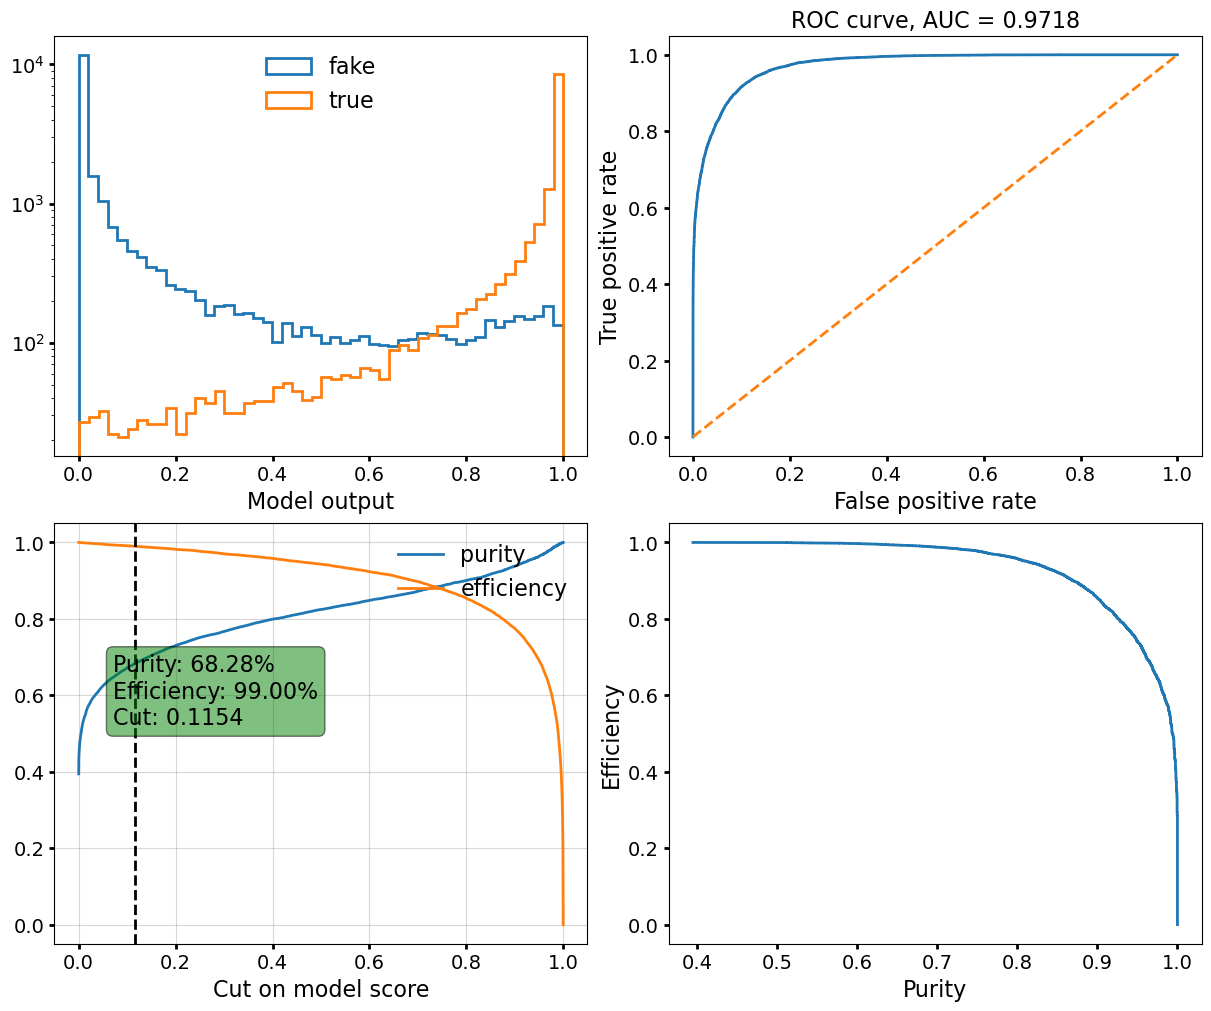

In [5]:
edge_perf = EdgePerformance(reader)
weights = data.weights

edges = data.edge_index.cpu().numpy()
hits_of_interest = np.unique(edges[:, weights == 5])
edges_of_interest = np.isin(edges[0], hits_of_interest) & np.isin(edges[1], hits_of_interest)
print("Number of edges of interest: {:,}".format(edges_of_interest.sum()))
edge_perf.eval_edge_scores(data.scores[edges_of_interest], data.y[edges_of_interest], outname="test_gnn_evt{}".format(0))

Number of edges of interest: 37,638
                     0.10    0.50    0.80
Accuracy:            0.8581 0.9136 0.9023
Precision (purity):  0.7411 0.8794 0.9437
Recall (efficiency): 0.9844 0.9052 0.8000
AUC: 0.9765
Purity at 0.7024 efficiency: 0.9900 with cut 0.0633


(<Figure size 1200x1000 with 4 Axes>,
 array([<Axes: xlabel='Model output'>,
        <Axes: title={'center': 'ROC curve, AUC = 0.9765'}, xlabel='False positive rate', ylabel='True positive rate'>,
        <Axes: xlabel='Cut on model score'>,
        <Axes: xlabel='Purity', ylabel='Efficiency'>], dtype=object),
 0.9764932488513781,
 0.9900350121195799,
 0.7024315673816462,
 0.063320875)

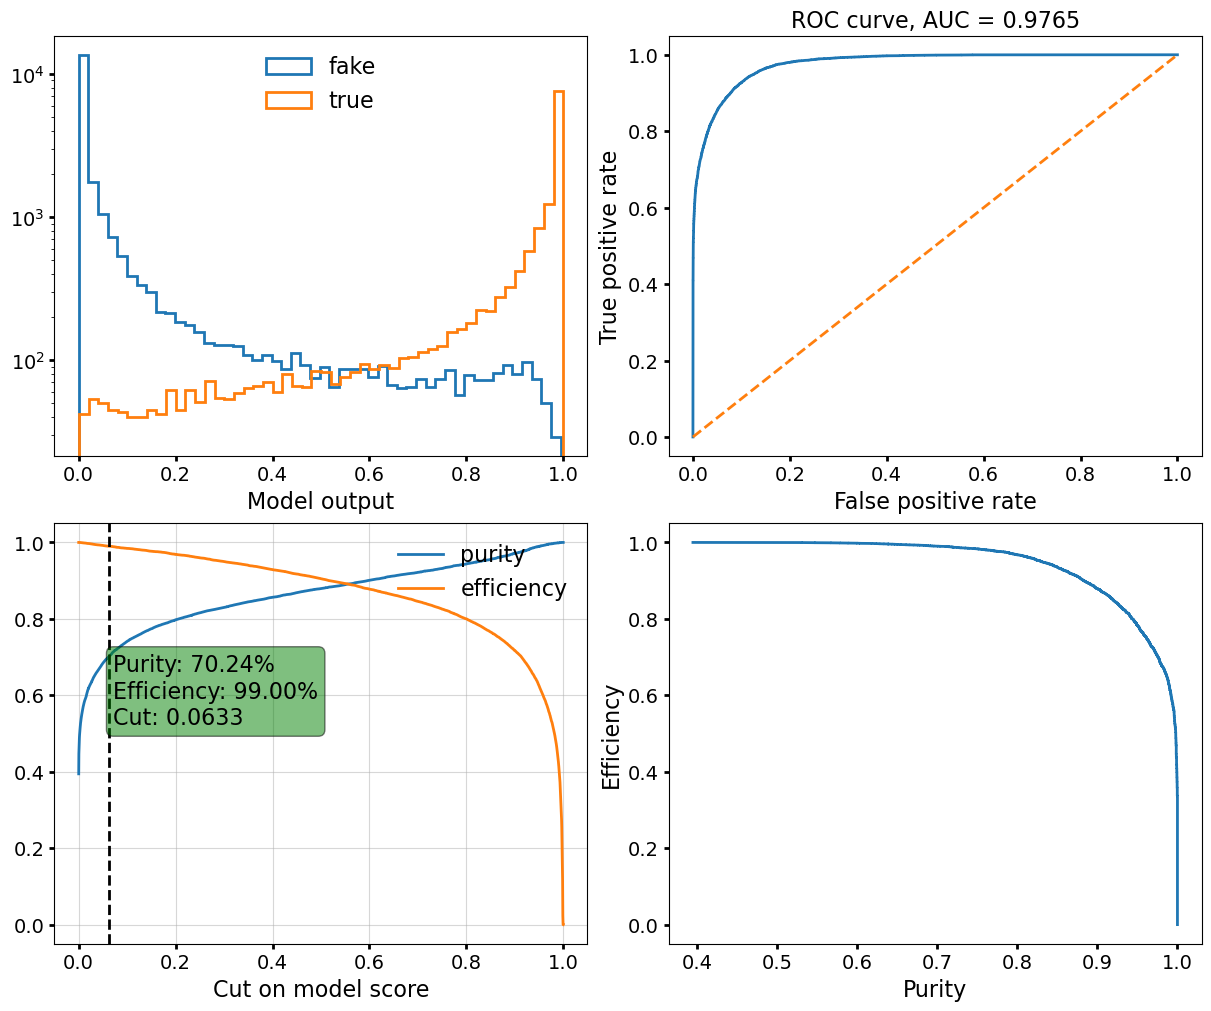

In [10]:
edge_perf = EdgePerformance(reader)
weights = data.weights

edges = data.edge_index.cpu().numpy()
hits_of_interest = np.unique(edges[:, weights == 5])
edges_of_interest = np.isin(edges[0], hits_of_interest) & np.isin(edges[1], hits_of_interest)
print("Number of edges of interest: {:,}".format(edges_of_interest.sum()))
edge_perf.eval_edge_scores(data.scores[edges_of_interest], data.y[edges_of_interest], outname="test_gnn_evt{}".format(0))

                     0.10    0.50    0.80
Accuracy:            0.7725 0.9155 0.9522
Precision (purity):  0.1694 0.3416 0.5320
Recall (efficiency): 0.8850 0.7065 0.5349
AUC: 0.9159
Purity at 0.0715 efficiency: 0.9900 with cut 0.0016


(<Figure size 1200x1000 with 4 Axes>,
 array([<Axes: xlabel='Model output'>,
        <Axes: title={'center': 'ROC curve, AUC = 0.9159'}, xlabel='False positive rate', ylabel='True positive rate'>,
        <Axes: xlabel='Cut on model score'>,
        <Axes: xlabel='Purity', ylabel='Efficiency'>], dtype=object),
 0.9159088856493509,
 0.990005595825254,
 0.0714853543117673,
 0.0015596553)

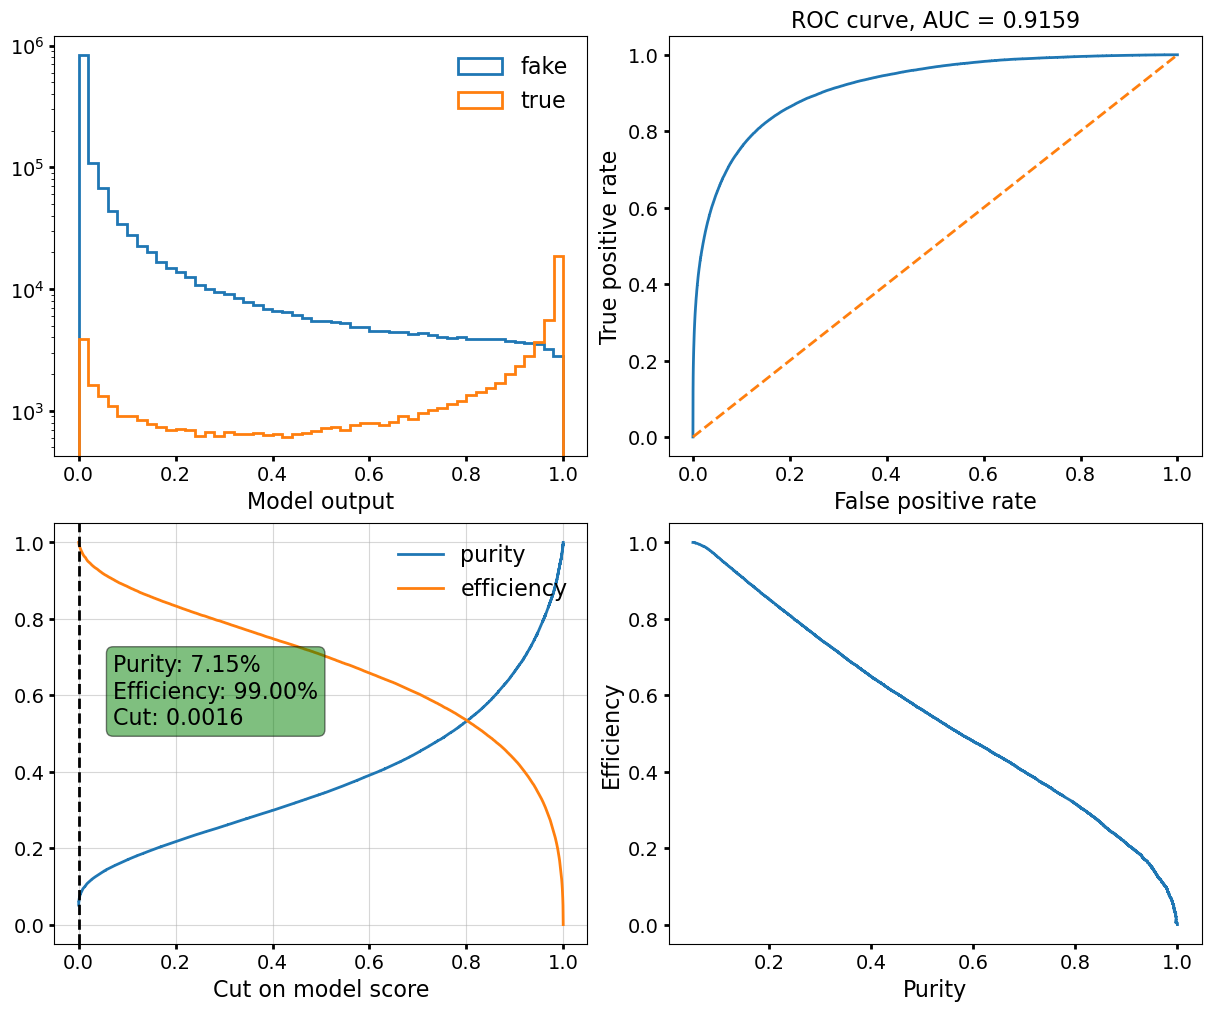

In [6]:
edge_perf.eval_edge_scores(data.scores, data.y, outname="perf_gnn_inclusive_evt{}".format(0))

In [27]:
edge_perf = EdgePerformance(reader)

Number of edges of interest: 37,638
                     0.10    0.50    0.80
Accuracy:            0.7158 0.8363 0.8923
Precision (purity):  0.5815 0.7108 0.8052
Recall (efficiency): 0.9984 0.9865 0.9592
AUC: 0.9729
Purity at 0.6854 efficiency: 0.9900 with cut 0.4109


(<Figure size 1200x1000 with 4 Axes>,
 array([<Axes: xlabel='Model output'>,
        <Axes: title={'center': 'ROC curve, AUC = 0.9729'}, xlabel='False positive rate', ylabel='True positive rate'>,
        <Axes: xlabel='Cut on model score'>,
        <Axes: xlabel='Purity', ylabel='Efficiency'>], dtype=object),
 0.9729026178041909,
 0.9900350121195799,
 0.6854053046194005,
 0.4108796)

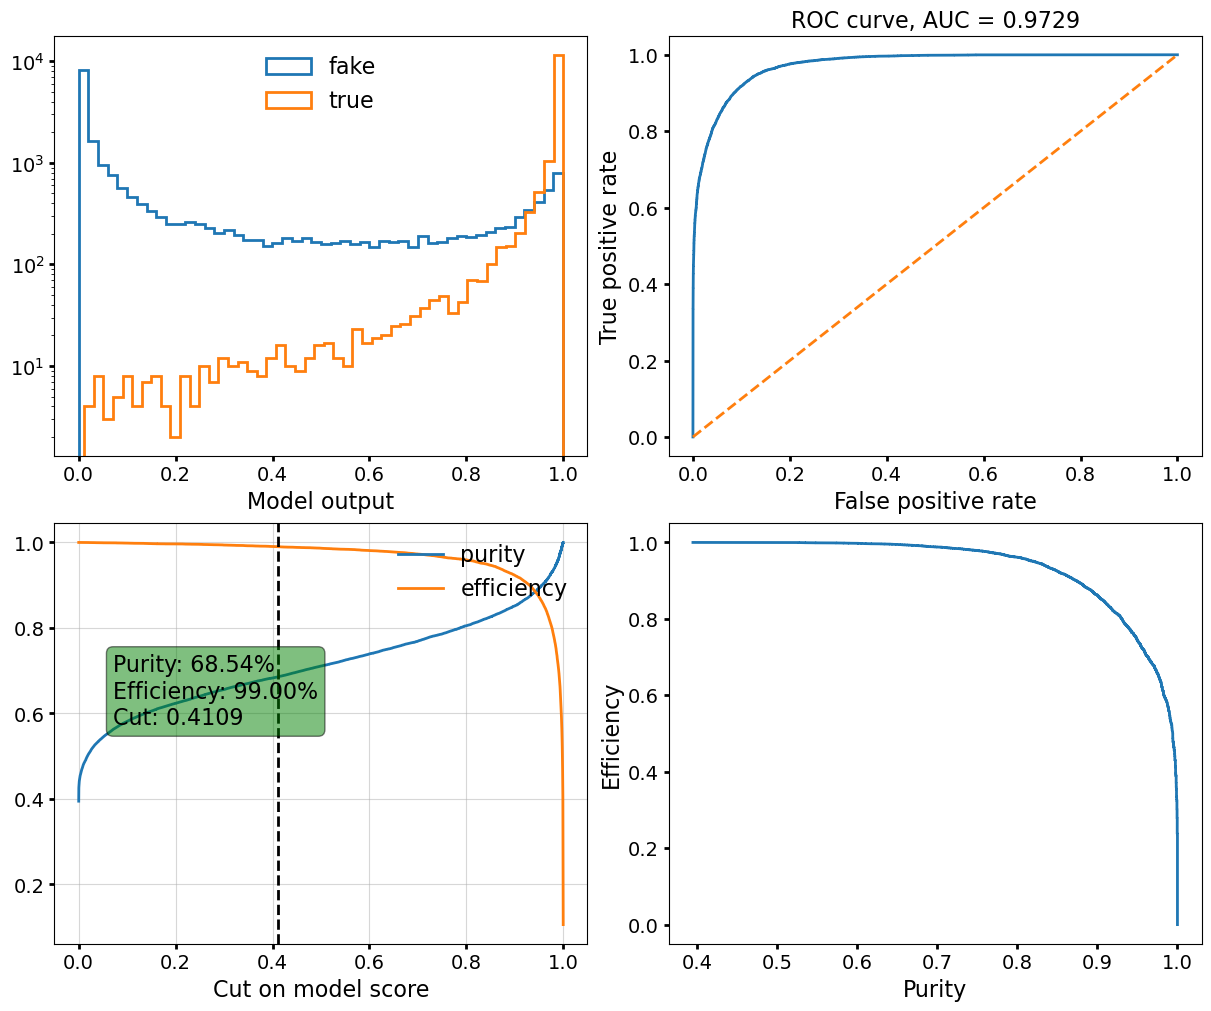

In [28]:
weights = data.weights

edges = data.edge_index.cpu().numpy()
hits_of_interest = np.unique(edges[:, weights == 5])
edges_of_interest = np.isin(edges[0], hits_of_interest) & np.isin(edges[1], hits_of_interest)
print("Number of edges of interest: {:,}".format(edges_of_interest.sum()))
edge_perf.eval_edge_scores(data.scores[edges_of_interest], data.y[edges_of_interest], outname="test_gnn_evt{}".format(0))

                     0.10    0.50    0.80
Accuracy:            0.6408 0.8256 0.9057
Precision (purity):  0.1188 0.2064 0.3177
Recall (efficiency): 0.9403 0.8483 0.7378
AUC: 0.9161
Purity at 0.0685 efficiency: 0.9900 with cut 0.0030


(<Figure size 1200x1000 with 4 Axes>,
 array([<Axes: xlabel='Model output'>,
        <Axes: title={'center': 'ROC curve, AUC = 0.9161'}, xlabel='False positive rate', ylabel='True positive rate'>,
        <Axes: xlabel='Cut on model score'>,
        <Axes: xlabel='Purity', ylabel='Efficiency'>], dtype=object),
 0.9160512436354905,
 0.990005595825254,
 0.06852066518411636,
 0.0029867338)

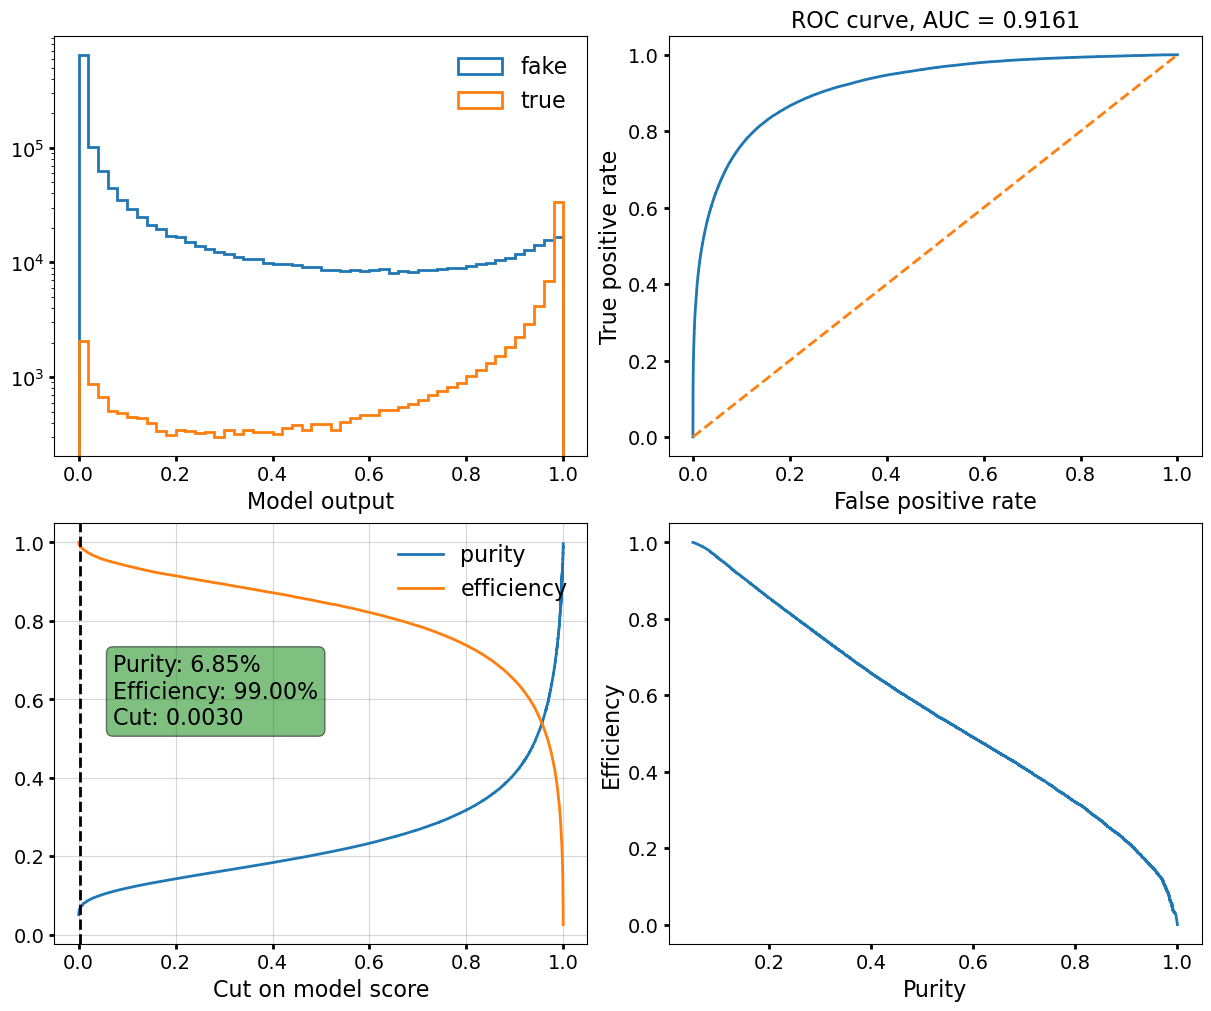

In [29]:
edge_perf = EdgePerformance(reader)
edge_perf.eval_edge_scores(data.scores, data.y, outname="perf_gnn_evt{}".format(0))


In [20]:
weights[weights == 0].shape

torch.Size([61992])

                     0.10    0.50    0.80
Accuracy:            0.6386 0.8521 0.9281
Precision (purity):  0.1231 0.2511 0.4068
Recall (efficiency): 0.9923 0.9561 0.8897
AUC: 0.9714
Purity at 0.1346 efficiency: 0.9900 with cut 0.1301
                     0.10    0.50    0.80
Accuracy:            0.6234 0.8479 0.9302
Precision (purity):  0.0266 0.0622 0.1225
Recall (efficiency): 0.9976 0.9794 0.9377
AUC: 0.9841
Purity at 0.0440 efficiency: 0.9900 with cut 0.3051


(<Figure size 1200x1000 with 4 Axes>,
 array([<Axes: xlabel='Model output'>,
        <Axes: title={'center': 'ROC curve, AUC = 0.9714'}, xlabel='False positive rate', ylabel='True positive rate'>,
        <Axes: xlabel='Cut on model score'>,
        <Axes: xlabel='Purity', ylabel='Efficiency'>], dtype=object),
 0.9713843426557799,
 0.990005595825254,
 0.13461004227188839,
 0.13007177)

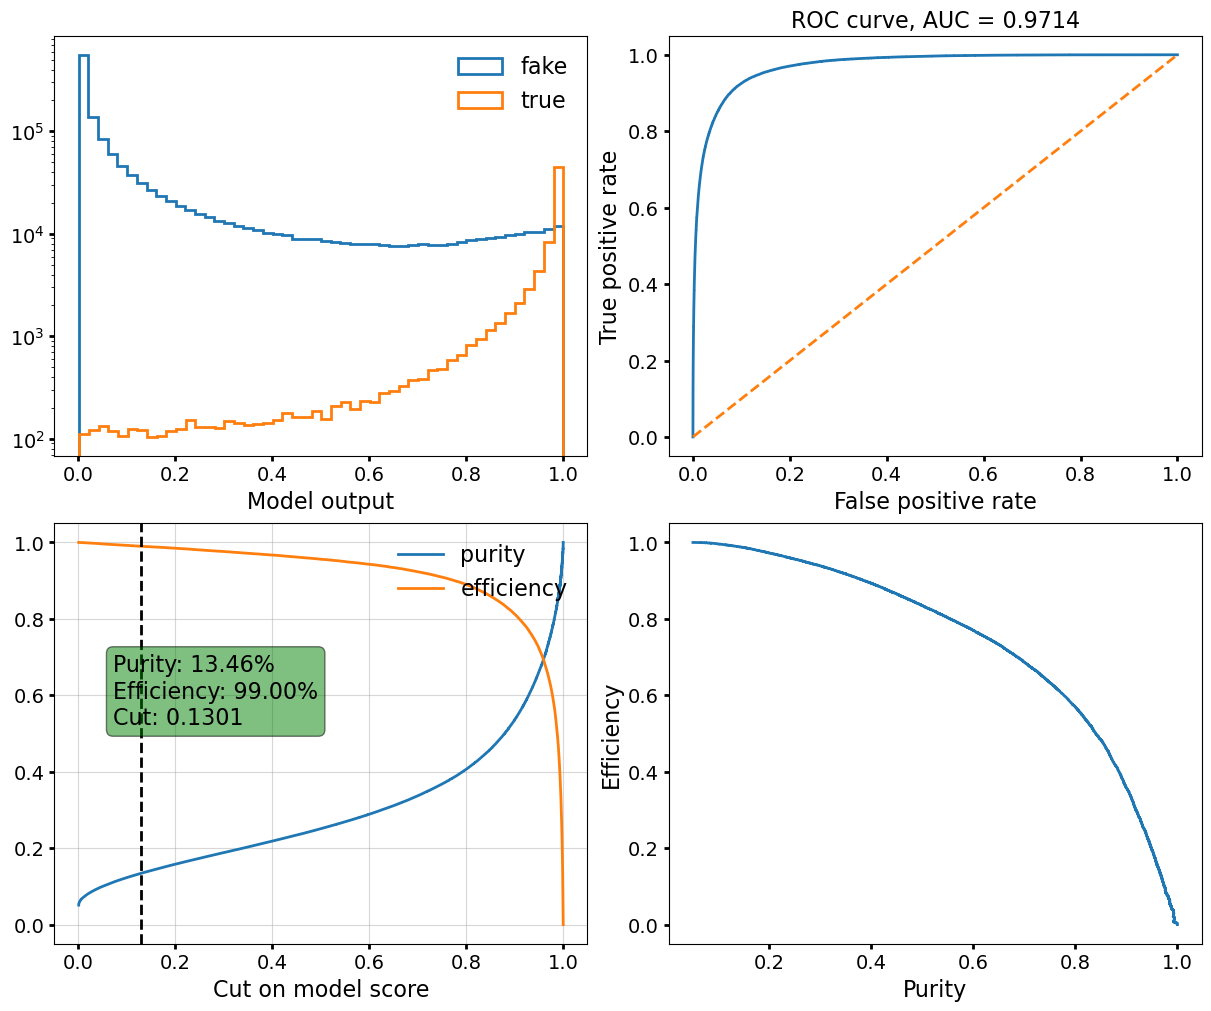

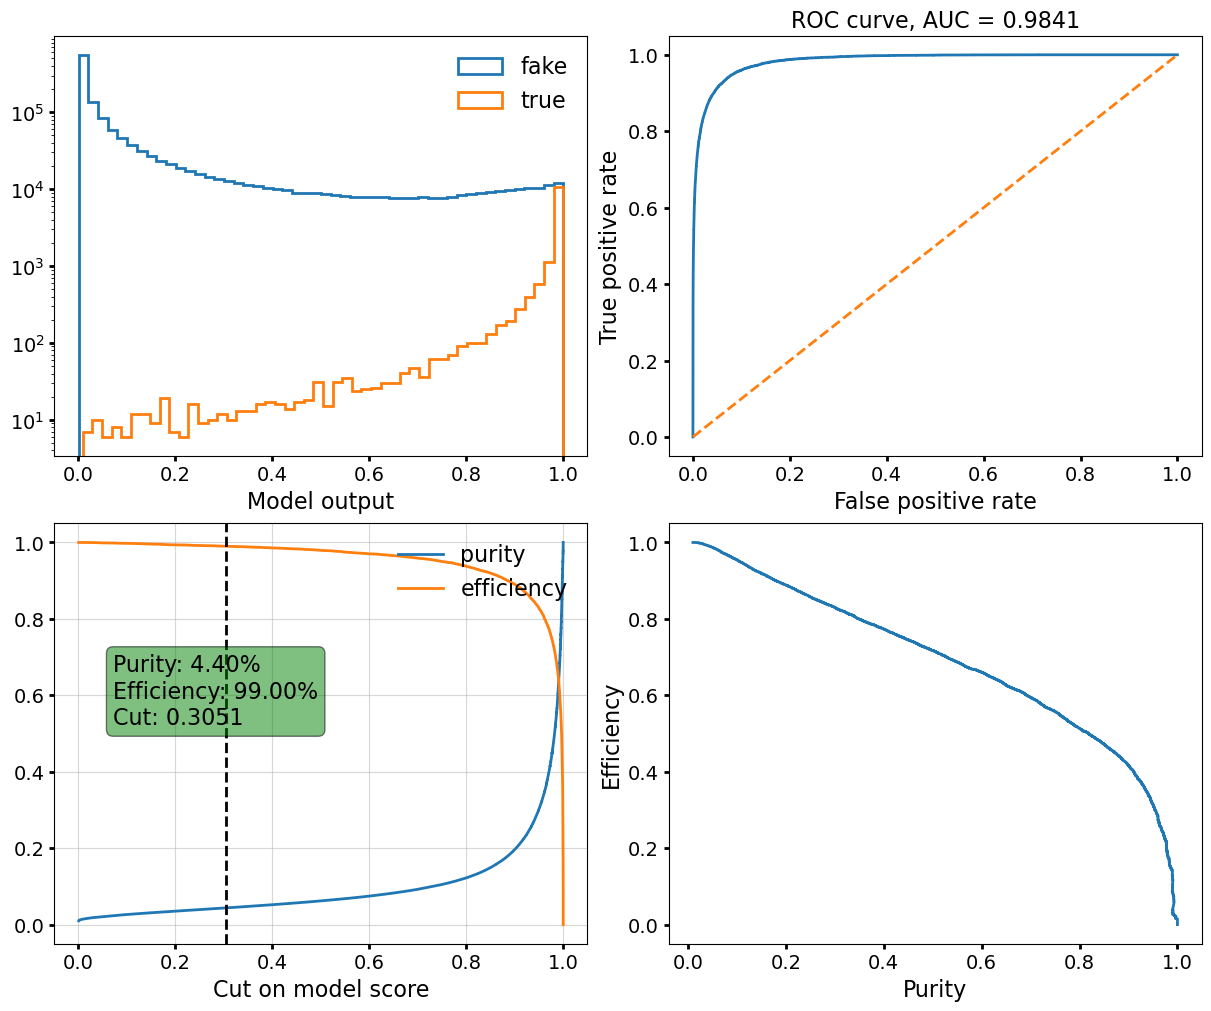

In [17]:
weights = data.weights

hits_of_interest = np.unique(data.edge_index[weights == 10].cpu().numpy())
edges_of_interest = data.edge_index[:, data.edge_index[0].isin(hits_of_interest) & data.edge_index[1].isin(hits_of_interest)]

edge_perf.eval_edge_scores(data.scores, data.y, weights, outname="perf_gnn_evt{}".format(0))

In [17]:
data.particle_id.shape, data.truth_map.shape, data.x.shape, 

(torch.Size([108249]), torch.Size([108249]), torch.Size([275435]))

In [12]:
pidx = data.particle_id == 515
hits = data.truth_map[pidx]

In [26]:
hit_idx = np.isin(data.hit_id.cpu().numpy(), hits)
hit_idx.shape

(275435,)

In [29]:
data.hit_id

tensor([     0,      1,      2,  ..., 275432, 275433, 275434])

In [11]:
data.particle_id.unique()[0:10]

tensor([512, 515, 540, 543, 566, 579, 581, 582, 583, 587])

In [31]:
sentences = 'Donald Trump was charged with four federal counts related to his efforts to overturn the 2020 presidential election and the January 6th attack on the Capitol. The charges—brought by Jack Smith, an independent special counsel—accuse the former president of conspiring to defraud America, to obstruct an “official proceeding” (the certification of the vote) and to deprive people of their right to vote and have their vote counted. Mr Trump dismissed the charges as a Fake Indictment'
words = sentences.split()
import random
random_words = random.shuffle(words)
print(words)

['to', 'president', 'the', 'federal', 'with', 'certification', '6th', 'proceeding”', 'charges—brought', 'and', 'Mr', 'by', 'Trump', 'America,', 'was', 'his', 'deprive', 'vote', '(the', 'independent', 'have', 'of', 'overturn', 'charged', 'their', 'obstruct', 'attack', 'counts', 'defraud', 'Smith,', 'related', 'dismissed', 'Jack', 'to', 'Trump', 'The', '“official', 'the', 'charges', 'efforts', 'election', 'Indictment', 'Donald', 'Fake', 'on', 'to', 'vote', 'an', 'counsel—accuse', 'and', 'a', 'counted.', '2020', 'four', 'and', 'presidential', 'the', 'their', 'right', 'the', 'vote)', 'of', 'the', 'the', 'people', 'as', 'January', 'an', 'of', 'to', 'former', 'conspiring', 'Capitol.', 'special', 'to', 'to']


## Inference Pipeline

In [4]:
data_path = base_path + "/metric_learning_testing/trainset"
reader = TrackGraphDataReader(data_path, name="Embedding")
data = reader.read(0)

Embedding: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/metric_learning_testing/trainset
Reading file: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/metric_learning_testing/trainset/event000001693.pyg


In [29]:
import yaml
with open(config_file, "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [8]:
econfig = config["embedding"]
node_features = econfig["node_features"]
node_scales = econfig["node_scales"]

features = reader.get_node_features(node_features, node_scales)

In [9]:
embedding_model_path = config['embedding']["model_path"]
embedding = torch.jit.load(embedding_model_path)
embedding.eval()

RecursiveScriptModule(
  original_name=MetricLearning
  (network): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=LayerNorm)
    (2): RecursiveScriptModule(original_name=ReLU)
    (3): RecursiveScriptModule(original_name=Linear)
    (4): RecursiveScriptModule(original_name=LayerNorm)
    (5): RecursiveScriptModule(original_name=ReLU)
    (6): RecursiveScriptModule(original_name=Linear)
    (7): RecursiveScriptModule(original_name=LayerNorm)
    (8): RecursiveScriptModule(original_name=ReLU)
    (9): RecursiveScriptModule(original_name=Linear)
    (10): RecursiveScriptModule(original_name=LayerNorm)
    (11): RecursiveScriptModule(original_name=ReLU)
    (12): RecursiveScriptModule(original_name=Linear)
  )
)

In [10]:
embedding_features = embedding.forward(features)

In [11]:
edge_index = build_edges(embedding_features, r_max=r_max, k_max=k_max, backend="FRNN")

In [12]:
edge_index.device

device(type='cuda', index=0)

In [13]:
filtering_model = torch.jit.load(filtering_model_path, map_location=torch.device('cuda'))
filtering_model.eval()

RecursiveScriptModule(
  original_name=PermutationInvariantFilter
  (encoder): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=LayerNorm)
    (2): RecursiveScriptModule(original_name=ReLU)
    (3): RecursiveScriptModule(original_name=Linear)
    (4): RecursiveScriptModule(original_name=LayerNorm)
    (5): RecursiveScriptModule(original_name=ReLU)
    (6): RecursiveScriptModule(original_name=Linear)
    (7): RecursiveScriptModule(original_name=LayerNorm)
    (8): RecursiveScriptModule(original_name=ReLU)
    (9): RecursiveScriptModule(original_name=Linear)
    (10): RecursiveScriptModule(original_name=LayerNorm)
    (11): RecursiveScriptModule(original_name=ReLU)
  )
  (decoder): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=LayerNorm)
    (2): RecursiveScriptModule(original_name=ReLU

In [14]:
fconfig = config['filtering']
filter_node_features = fconfig["node_features"]
filter_node_scales = fconfig["node_scales"]
filter_data_features = reader.get_node_features(filter_node_features, filter_node_scales)

In [15]:
filter_data_features.shape, filter_data_features.device, edge_index.shape, edge_index.device

(torch.Size([275435, 25]),
 device(type='cpu'),
 torch.Size([2, 12688584]),
 device(type='cpu'))

In [15]:
senders, receivers = filter_data_features[edge_index[0]], filter_data_features[edge_index[1]]

In [19]:
device = 'cuda'
senders = senders.to(device)
receivers = receivers.to(device)

In [16]:
from acctrack.tools.model_inference import batched_inference

In [20]:
filtering_edge_scores = batched_inference(filtering_model, senders, receivers, batch_size=1_000_000)

In [19]:
with torch.no_grad():
    batch_size = 1024
    filtering_edge_scores = filtering_model.forward(senders[:batch_size], receivers[:batch_size])

In [22]:
filtering_edge_scores = torch.sigmoid(filtering_edge_scores)

In [23]:
threshold = 0.57
filtering_selections = filtering_edge_scores > threshold
edge_index_after_filter = edge_index[:, filtering_selections]

In [24]:
edge_index_after_filter.shape

torch.Size([2, 2571692])

In [30]:
g_config = config.get('gnn', None)
node_features = g_config['node_features']
node_scales = g_config['node_scales']
features = reader.get_node_features(node_features, node_scales)

In [33]:
edge_index_after_filter

tensor([[     0,      1,      1,  ..., 275434, 275434, 275434],
        [    82,  14316,  14326,  ..., 271519, 271534, 271540]],
       device='cuda:0')

In [66]:
import onnx
onnx_model = onnx.load(gnn_onnx_path)
onnx.checker.check_model(onnx_model)

In [88]:
session = ort.InferenceSession(gnn_onnx_path, providers=['CUDAExecutionProvider'])
output = np.zeros(edge_index_after_filter.shape[1], dtype=np.float32)
gnn_output = session.run(None, 
                         {"x": features.cpu().numpy(), 
                          "edge_index": edge_index_after_filter.cpu().numpy()})

In [85]:
gnn_output[0], features

(array([[ 0.03337711, -0.99692905, -0.08833333, ..., -0.75037897,
          0.41635   ,  1.24905   ],
        [ 0.03405646,  0.9399043 , -0.08833333, ..., -0.75037897,
          0.327598  ,  0.982794  ],
        [ 0.03345403, -0.9918591 , -0.08833333, ..., -0.75037897,
          0.327598  ,  0.982794  ],
        ...,
        [ 0.94284904, -0.03746629,  0.9514167 , ...,  0.45214328,
          0.44154668,  0.00637931],
        [ 0.9620676 , -0.03931001,  0.9514167 , ...,  0.45214328,
          0.44154668,  0.00637931],
        [ 0.95497763, -0.06019103,  0.9514167 , ...,  0.45214328,
          0.44154668,  0.00637931]], dtype=float32),
 tensor([[ 0.0334, -0.9969, -0.0883,  ..., -0.7504,  0.4164,  1.2491],
         [ 0.0341,  0.9399, -0.0883,  ..., -0.7504,  0.3276,  0.9828],
         [ 0.0335, -0.9919, -0.0883,  ..., -0.7504,  0.3276,  0.9828],
         ...,
         [ 0.9428, -0.0375,  0.9514,  ...,  0.4521,  0.4415,  0.0064],
         [ 0.9621, -0.0393,  0.9514,  ...,  0.4521,  0.4415,

## Exam scattering

Each node may be connected to `n` number of edges and each edge may have `m` features. The goal is to *aggregate* the edge features for each node, which will result in a `1 x m` vector for each node. The aggregation function can be mean, sum, max, etc. In this example, we will use sum.

In [188]:
num_e = 20
num_e_features = 5
num_v = 10
torch.random.manual_seed(42)
edge_features = torch.rand((num_e_features, num_e))
random_edge_indices = torch.randint(0, num_v, (2, num_e))

# the node in question is a sender
senders = random_edge_indices[0:1, :]
senders = senders.tile(num_e_features, 1)

results = torch.zeros(num_e_features, num_v, dtype=edge_features.dtype)
results = results.scatter_add(1, senders, edge_features).T
results


tensor([[2.5088, 1.1852, 1.9365, 0.6992, 1.3370],
        [2.3046, 2.2934, 2.1995, 2.1434, 2.3420],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.9150, 0.4414, 0.3644, 0.1587, 0.1591],
        [0.5936, 0.0753, 0.3068, 0.6666, 0.3725],
        [3.0912, 2.6892, 2.4940, 2.3940, 1.9373],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.5670, 0.6016, 2.0889, 1.5110, 1.6803],
        [0.7606, 0.3485, 0.3400, 1.1172, 0.6686],
        [1.0033, 1.7130, 1.1984, 0.8113, 0.5643]])

In [197]:
edge_features = torch.rand((num_e,num_e_features))
random_edge_indices = torch.randint(0, num_v, (2, num_e))
senders = random_edge_indices[0:1, :]
senders = senders.tile(num_e_features, 1).T

results = torch.zeros(num_v, num_e_features, dtype=edge_features.dtype)
results = results.scatter_add(0, senders, edge_features)

In [199]:
results

tensor([[1.6229, 1.0722, 0.9872, 1.4357, 0.4548],
        [1.3313, 1.7635, 1.2490, 1.3414, 1.3200],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [2.0056, 0.8538, 1.1922, 1.7726, 1.0956],
        [0.8989, 0.4269, 0.5095, 0.7985, 0.9347],
        [1.2984, 1.6955, 1.9325, 2.4139, 1.2235],
        [1.8800, 1.8058, 2.1856, 1.4639, 1.9251],
        [0.0343, 0.3092, 0.0702, 0.1836, 0.7785],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.6100, 1.0941, 0.8844, 0.7959, 0.8228]])

### agrr in pyg

In [174]:
from torch_geometric.nn import aggr
sum_aggr = aggr.SumAggregation()

In [179]:
edge_features.shape, random_edge_indices.shape

(torch.Size([5, 20]), torch.Size([2, 20]))

In [180]:
sum_aggr(edge_features.T, random_edge_indices[0])

tensor([[2.5088, 1.1852, 1.9365, 0.6992, 1.3370],
        [2.3046, 2.2934, 2.1995, 2.1434, 2.3420],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.9150, 0.4414, 0.3644, 0.1587, 0.1591],
        [0.5936, 0.0753, 0.3068, 0.6666, 0.3725],
        [3.0912, 2.6892, 2.4940, 2.3940, 1.9373],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.5670, 0.6016, 2.0889, 1.5110, 1.6803],
        [0.7606, 0.3485, 0.3400, 1.1172, 0.6686],
        [1.0033, 1.7130, 1.1984, 0.8113, 0.5643]])

In [41]:
edge_perf = EdgePerformance(reader)

In [43]:
truth_labels, true_edges, per_edge_efficiency, per_edge_purity = edge_perf.eval(edge_index)

True Reco Edges 163,492, True Edges 216,498, Per-edge efficiency: 75.517%
True Edges 216,498, Reco Edges 12,688,452, Per-edge purity: 1.706%
Only 12.141% of true edges are of interests (signal)
True Reco Signal Edges 26,194, True Signal Edges 26,286, Per-edge signal efficiency: 99.650%


                     0.10    0.50    0.80
Accuracy:            0.5795 0.7861 0.8803
Precision (purity):  0.0292 0.0513 0.0795
Recall (efficiency): 0.9804 0.8926 0.7838
AUC: 0.9264
Purity at 0.0248 efficiency: 0.9900 with cut 0.0524


(<Figure size 1200x1000 with 4 Axes>,
 array([<Axes: xlabel='Model output'>,
        <Axes: title={'center': 'ROC curve, AUC = 0.9264'}, xlabel='False positive rate', ylabel='True positive rate'>,
        <Axes: xlabel='Cut on model score'>,
        <Axes: xlabel='Purity', ylabel='Efficiency'>], dtype=object),
 0.9263716055843011,
 0.9900056271866513,
 0.024800692577014716,
 0.05240802)

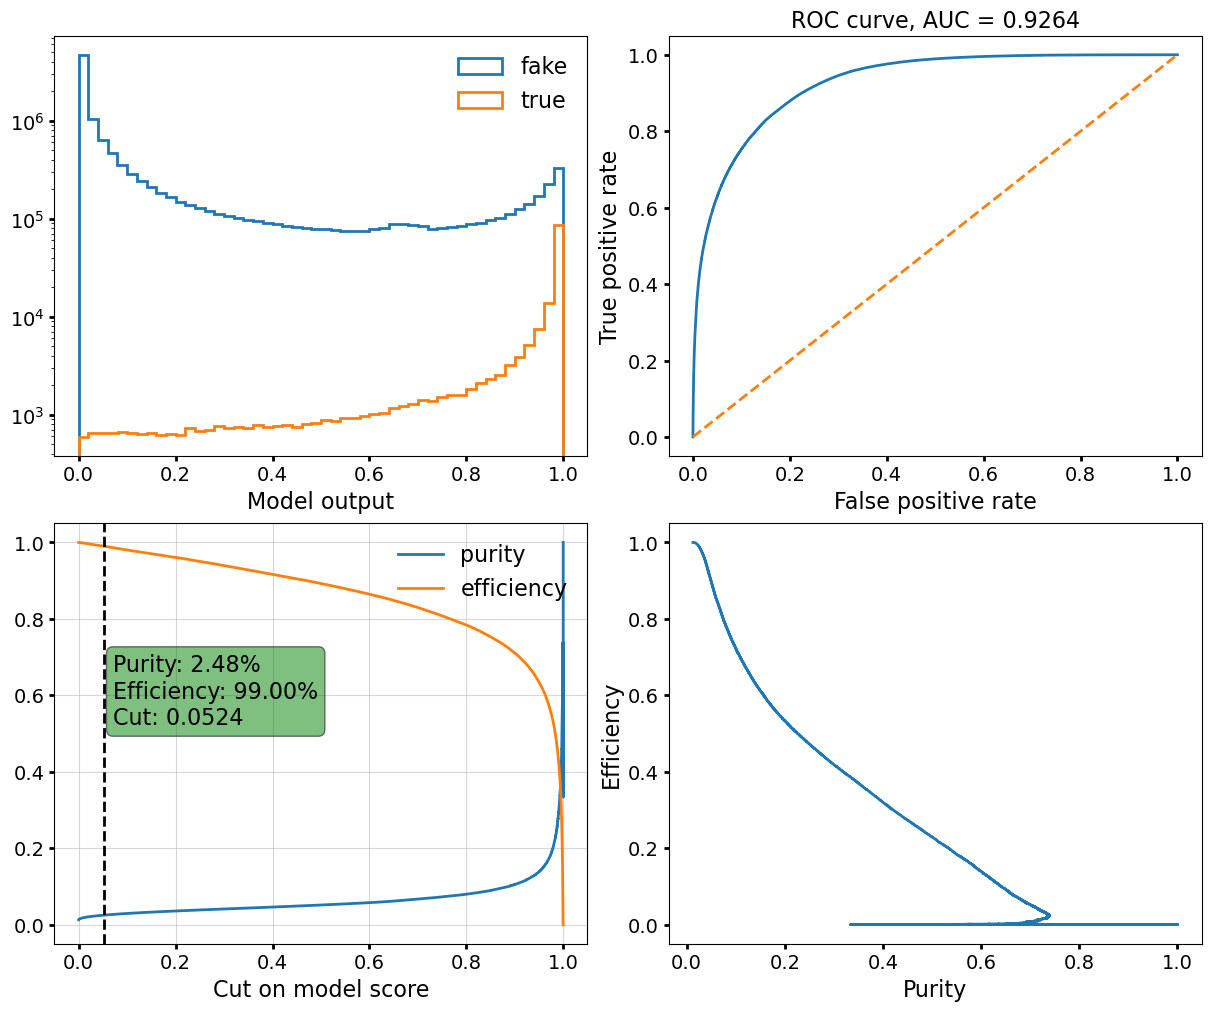

In [44]:
edge_perf.eval_edge_scores(filtering_edge_scores, truth_labels, outname="perf_filtering_evt{}".format(0))

In [50]:
edge_perf.eval_edge_scores(gnn_output, truth_labels[filtering_selections], 
                           outname="perf_filtering_evt{}".format(0))

ValueError: Found input variables with inconsistent numbers of samples: [2571692, 275435]

In [42]:
batch_size = 1024
filtering_edge_scores = filtering_model.forward(senders[:batch_size], receivers[:batch_size])
filtering_edge_scores

tensor([ 2.9057, -0.6808,  1.4122,  ...,  1.7383, -1.4039,  1.5612],
       grad_fn=<DifferentiableGraphBackward>)

In [39]:
filtering_edge_scores

tensor([ 2.9057, -0.6808,  1.4122,  ...,  1.7383, -1.4039,  1.5612],
       grad_fn=<SqueezeBackward1>)

In [38]:
filtering_edge_scores.detach()

tensor([ 2.9057, -0.6808,  1.4122,  ...,  1.7383, -1.4039,  1.5612])

In [36]:
jj = torch.concat([filtering_edge_scores, filtering_edge_scores], dim=0)
jj.shape

torch.Size([2048])

In [37]:
jj

tensor([ 2.9057, -0.6808,  1.4122,  ...,  1.7383, -1.4039,  1.5612],
       grad_fn=<CatBackward0>)

In [70]:
data.y.shape, data.edge_index.shape, data.track_edges.shape, data.pt.shape, data.nhits.shape

(torch.Size([8418480]),
 torch.Size([2, 8418480]),
 torch.Size([2, 108249]),
 torch.Size([108249]),
 torch.Size([108249]))

In [83]:
data.track_edges[0, data.track_edges[0] > 109249]

tensor([109251, 109254, 109256,  ..., 271532, 271533, 273373])

In [91]:
data.phi.shape, data.pt.shape, data.eta_angle_2.shape, data.particle_id.shape, data.pdgId.shape

(torch.Size([275435]),
 torch.Size([108249]),
 torch.Size([275435]),
 torch.Size([108249]),
 torch.Size([108249]))

In [93]:
data.truth_map.shape

torch.Size([108249])

In [79]:
max(data.track_edges[0]), max(data.track_edges[1])

(tensor(273373), tensor(275432))

In [78]:
data.track_edges[0]

tensor([     0,      3,      4,  ..., 271532, 271533, 273373])

In [71]:
data.primary

tensor([1., 1., 1.,  ..., 1., 1., 0.], dtype=torch.float64)

## Compare different trained Embedding models

In [100]:
version = 'v1'
model_files = {
    "v1": base_path + f"/TrainedModels/{version}/graph_construction-MetricLearning-v1.pt",
    "v2": base_path + f"/TrainedModels/{version}/graph_construction-MetricLearning-v2.pt",
    "v3": base_path + f"/TrainedModels/{version}/graph_construction-MetricLearning-v3.pt",
    "v4": base_path + f"/TrainedModels/{version}/graph_construction-MetricLearning-v4.pt",
    "v5": base_path + f"/TrainedModels/{version}/graph_construction-MetricLearning-v5.pt",
}

In [101]:

models = { k: TorchModelInference(config_file, "trainset", v, ".", name=k) for k, v in model_files.items() }

Training: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/trainset
Validation: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/valset
Test: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/testset
Training: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/trainset
Validation: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/valset
Test: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/testset
Training: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/trainset
Validation: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/valset
Test: Tota

In [103]:

results = { k: m.inference(0, knn_backend="FRNN") for k,m in models.items() }

Reading file: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/trainset/event000001693-graph.pyg
True Reco Edges 163,492, True Edges 216,498, Per-edge efficiency: 75.517%
True Edges 216,498, Reco Edges 12,688,452, Per-edge purity: 1.706%
Only 12.141452% of true edges are of interests (signal)
True Reco Signal Edges 26,194, True Signal Edges 26,286, Per-edge signal efficiency: 99.650%
Reading file: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/trainset/event000001693-graph.pyg
True Reco Edges 184,712, True Edges 216,498, Per-edge efficiency: 85.318%
True Edges 216,498, Reco Edges 29,230,107, Per-edge purity: 0.741%
Only 12.141452% of true edges are of interests (signal)
True Reco Signal Edges 26,068, True Signal Edges 26,286, Per-edge signal efficiency: 99.171%
Reading file: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/trainset/event000001693-graph.pyg
True Reco Edges 174,589, True Edges 216,498, 

### How about validation dataset?

In [104]:

models = { k: TorchModelInference(config_file, "valset", v, ".", name=k) for k, v in model_files.items() }
results = { k: m.inference(0, knn_backend="FRNN") for k,m in models.items() }

Loading model from /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper//TrainedModels/v1/graph_construction-MetricLearning-v1.pt
valset: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/valset
Loading model from /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper//TrainedModels/v1/graph_construction-MetricLearning-v2.pt
valset: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/valset
Loading model from /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper//TrainedModels/v1/graph_construction-MetricLearning-v3.pt
valset: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/valset
Loading model from /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper//TrainedModels/v1/graph_construction-MetricLearning-v4.pt
valset: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/valset
Load

## Verify graph intersections

In [19]:
edge_index = torch.tensor([[1, 3], [2, 3], [2, 4], [3, 4], [1, 4], [3, 1]], dtype=torch.long).T
true_edges = torch.tensor([[1, 2], [2, 3], [3, 1]], dtype=torch.long).T

In [20]:
edge_index.shape

torch.Size([2, 6])

In [21]:
unique_edges, inverse = torch.unique(torch.cat([edge_index, true_edges], dim=1), dim=1, sorted=False, return_inverse=True, return_counts=False)


In [23]:
unique_edges, inverse

(tensor([[1, 1, 1, 2, 2, 3, 3],
         [2, 3, 4, 3, 4, 1, 4]]),
 tensor([1, 3, 4, 6, 2, 5, 0, 3, 5]))

In [24]:
inverse_pred_map = torch.ones_like(unique_edges[1]) * -1
inverse_pred_map

tensor([-1, -1, -1, -1, -1, -1, -1])

In [25]:
inverse_pred_map[inverse[:edge_index.shape[1]]] = torch.arange(edge_index.shape[1])

In [26]:
inverse_pred_map

tensor([-1,  0,  4,  1,  2,  5,  3])

In [27]:
inverse_truth_map = torch.ones_like(unique_edges[1]) * -1
inverse_truth_map[inverse[edge_index.shape[1]:]] = torch.arange(true_edges.shape[1])

In [28]:
inverse_truth_map

tensor([ 0, -1, -1,  1, -1,  2, -1])

In [34]:
inverse_truth_map[inverse]

tensor([-1,  1, -1, -1, -1,  2,  0,  1,  2])

In [35]:
pred_to_truth = inverse_truth_map[inverse[:edge_index.shape[1]]]
truth_to_pred = inverse_pred_map[inverse][edge_index.shape[1]:]

In [32]:
inverse.shape, inverse_truth_map.shape

(torch.Size([9]), torch.Size([7]))

In [33]:
pred_to_truth

tensor([-1,  1, -1, -1, -1,  2])

In [36]:
pred_to_truth

tensor([-1,  1, -1, -1, -1,  2])

In [31]:
truth_to_pred

tensor([-1,  1,  5])